In [ ]:
!pip install tableone

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from tableone import TableOne
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/scientometrics')

print("Current Working Directory:", os.getcwd())

Mounted at /content/drive
Current Working Directory: /content/drive/My Drive/scientometrics


In [ ]:
df = pd.read_csv(f"clean/max_30_authors.csv")

In [ ]:
df.head()

,pub_id,researcher_id,journal,year,gender,aff_country_code,aff_id,LMIC
0,pub.1000001707,ur.01006172666.33,JAMA,2015,female,US,grid.411024.2,0.0
1,pub.1000001707,ur.01012736025.78,JAMA,2015,male,US,NaN,0.0
2,pub.1000001707,ur.010132635727.81,JAMA,2015,male,US,grid.266102.1,0.0
3,pub.1000001707,ur.01023477132.25,JAMA,2015,female,US,grid.62560.37,0.0
4,pub.1000001707,ur.01043100547.54,JAMA,2015,female,US,grid.267308.8,0.0


## author-level, conditional on gender/income

### gender

In [ ]:
import pandas as pd
from scipy.stats import chisquare

# Initialize counts
first_author_counts = {'female': 0, 'male': 0}
middle_author_counts = {'female': 0, 'male': 0}
last_author_counts = {'female': 0, 'male': 0}
total_counts = {'female': 0, 'male': 0}

# Function to update counts
def update_counts(group):
    global first_author_counts, middle_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

    if len(gender_list) > 2:
        middle_genders = gender_list[1:-1]
        middle_author_counts['female'] += middle_genders.count('female')
        middle_author_counts['male'] += middle_genders.count('male')

# Apply function to each group
df.groupby('pub_id').apply(update_counts)

# Calculate probabilities
prob_first_author = {k: (v / total_counts[k]) * 100 for k, v in first_author_counts.items()}
prob_middle_author = {k: (v / total_counts[k]) * 100 for k, v in middle_author_counts.items()}
prob_last_author = {k: (v / total_counts[k]) * 100 for k, v in last_author_counts.items()}

# Prepare data for chi-squared tests
first_obs = [first_author_counts['female'], first_author_counts['male']]
middle_obs = [middle_author_counts['female'], middle_author_counts['male']]
last_obs = [last_author_counts['female'], last_author_counts['male']]

# Perform chi-squared tests
_, p_value_first = chisquare(first_obs)
_, p_value_middle = chisquare(middle_obs)
_, p_value_last = chisquare(last_obs)

# Check if p-values are significant (alpha level 0.05)
is_first_significant = 'Yes' if p_value_first < 0.05/4 else 'No'
is_middle_significant = 'Yes' if p_value_middle < 0.05/44 else 'No'
is_last_significant = 'Yes' if p_value_last < 0.05/4 else 'No'

# Create DataFrame to store probabilities
prob_gender = pd.DataFrame({
    'Gender': ['female', 'male'],
    'Probability_First_Author': [prob_first_author['female'], prob_first_author['male']],
    'Probability_Middle_Author': [prob_middle_author['female'], prob_middle_author['male']],
    'Probability_Last_Author': [prob_last_author['female'], prob_last_author['male']]
})

# Add significance indicators as a new row
significance_row = pd.DataFrame({
    'Gender': ['Significant'],
    'Probability_First_Author': [is_first_significant],
    'Probability_Middle_Author': [is_middle_significant],
    'Probability_Last_Author': [is_last_significant]
})

prob_gender = pd.concat([prob_gender, significance_row], ignore_index=True)

In [ ]:
prob_gender

,Gender,Probability_First_Author,Probability_Middle_Author,Probability_Last_Author
0,female,18.047327,64.754032,17.896604
1,male,19.478546,61.803242,19.553089
2,Significant,Yes,Yes,Yes


### lmic

In [ ]:
import pandas as pd
from scipy.stats import chisquare

# Initialize counts
first_author_counts = {'LMIC': 0, 'HIC': 0}
middle_author_counts = {'LMIC': 0, 'HIC': 0}
last_author_counts = {'LMIC': 0, 'HIC': 0}
total_counts = {'LMIC': 0, 'HIC': 0}

# Function to update counts
def update_counts(group):
    global first_author_counts, middle_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

    if len(lmic_hic_list) > 2:
        middle_lmic_hic = lmic_hic_list[1:-1]
        middle_author_counts['LMIC'] += middle_lmic_hic.count(1.0)
        middle_author_counts['HIC'] += middle_lmic_hic.count(0.0)

# Apply function to each group
df.groupby('pub_id').apply(update_counts)

# Calculate probabilities
prob_first_author = {k: (v / total_counts[k]) * 100 for k, v in first_author_counts.items()}
prob_last_author = {k: (v / total_counts[k]) * 100 for k, v in last_author_counts.items()}

# Prepare data for chi-squared tests
first_obs = [first_author_counts['LMIC'], first_author_counts['HIC']]
last_obs = [last_author_counts['LMIC'], last_author_counts['HIC']]

# Perform chi-squared tests
_, p_value_first = chisquare(first_obs)
_, p_value_last = chisquare(last_obs)

# Check if p-values are significant (alpha level 0.05)
is_first_significant = 'Yes' if p_value_first < 0.05/4 else 'No'
is_last_significant = 'Yes' if p_value_last < 0.05/4 else 'No'

# Create DataFrame to store probabilities
prob_lmic_hic = pd.DataFrame({
    'Category': ['LMIC', 'HIC'],
    'Probability_First_Author': [prob_first_author['LMIC'], prob_first_author['HIC']],
    'Probability_Last_Author': [prob_last_author['LMIC'], prob_last_author['HIC']]
})

# Add significance indicators as a new row
significance_row = pd.DataFrame({
    'Category': ['Significant'],
    'Probability_First_Author': [is_first_significant],
    'Probability_Last_Author': [is_last_significant]
})

prob_lmic_hic = pd.concat([prob_lmic_hic, significance_row], ignore_index=True)


In [ ]:
prob_lmic_hic

,Category,Probability_First_Author,Probability_Last_Author
0,LMIC,16.243712,16.161729
1,HIC,17.940845,17.94955
2,Significant,Yes,Yes


### confidence intervals gender

In [ ]:
import numpy as np
import pandas as pd

def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  prob_gender = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

prob_gender

100%|██████████| 100/100 [13:45<00:00,  8.25s/it]


,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.167868,0.167848,0.003637,0.004176
1,male,0.180661,0.180671,0.001992,0.002094


### confidence intervals lmic

In [ ]:
import numpy as np
import pandas as pd

def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  prob_lmic_hic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

prob_lmic_hic

100%|██████████| 100/100 [13:13<00:00,  7.94s/it]


,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.154475,0.154683,0.007022,0.005145
1,HIC,0.168626,0.168604,0.000891,0.000926


### plot

In [ ]:
def add_asterisks(ax, rects1, rects2):
    for rect1, rect2 in zip(rects1, rects2):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        max_height = max(height1, height2)
        ax.text(rect1.get_x() + rect1.get_width(), max_height + 2, '*',
                ha='center', fontweight='bold')

def add_values(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

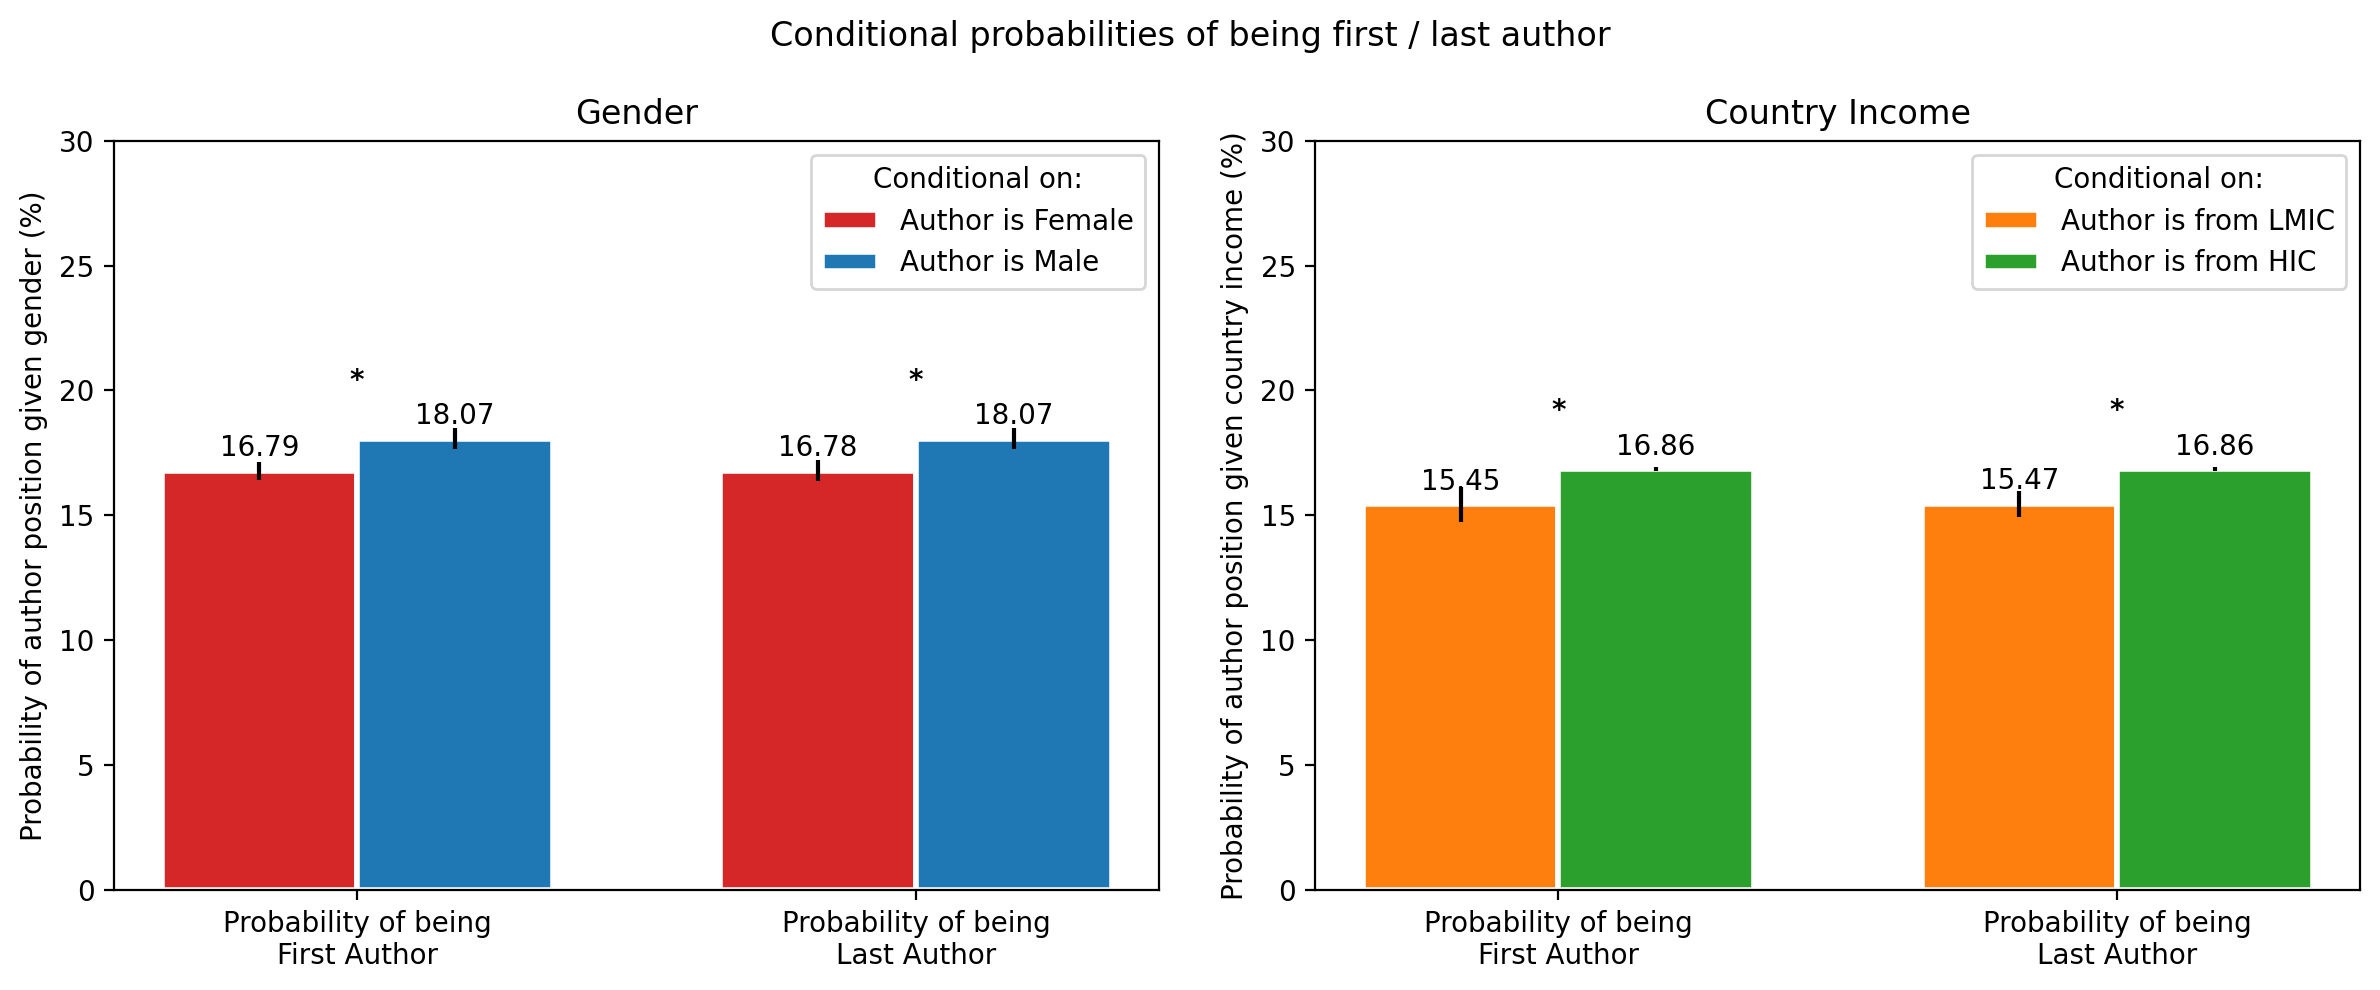

In [ ]:
# Data for gender
gender_labels = ['Probability of being\nFirst Author',
                 'Probability of being\nLast Author']
gender_minorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'Probability_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'Probability_Last_Author'].iloc[0]*100,
]
ci_g_minorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
]

gender_majorities = [
    prob_gender.loc[prob_gender['Gender'] == 'male', 'Probability_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'male', 'Probability_Last_Author'].iloc[0]*100,
]

ci_g_majorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
]

# Data for income
income_labels = ['Probability of being\nFirst Author',
                 'Probability of being\nLast Author']
income_minorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'Probability_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'Probability_Last_Author'].iloc[0]*100,
]

ci_i_minorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'CI_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'CI_Last_Author'].iloc[0]*100,
]

income_majorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'Probability_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'Probability_Last_Author'].iloc[0]*100,
]
ci_i_majorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'CI_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'CI_Last_Author'].iloc[0]*100,
]


# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting Gender
x_gender = np.arange(len(gender_labels))
width = 0.35
rects1_gender = ax1.bar(x_gender - width/2, gender_minorities, width, label='Author is Female',
                        color='tab:red', edgecolor='white', linewidth=2, yerr=ci_g_minorities)
rects2_gender = ax1.bar(x_gender + width/2, gender_majorities, width, label='Author is Male',
                        color='tab:blue', edgecolor='white', linewidth=2, yerr=ci_g_majorities)
ax1.set_title('Gender')
ax1.set_ylabel('Probability of author position given gender (%)')
ax1.set_xticks(x_gender)
ax1.set_xticklabels(gender_labels)
ax1.legend(title="Conditional on:")
ax1.set_ylim([0, 30])

# Plotting Income
x_income = np.arange(len(income_labels))
rects1_income = ax2.bar(x_income - width/2, income_minorities, width, label='Author is from LMIC',
                        color='tab:orange', edgecolor='white', linewidth=2, yerr=ci_i_minorities)
rects2_income = ax2.bar(x_income + width/2, income_majorities, width, label='Author is from HIC',
                        color='tab:green', edgecolor='white', linewidth=2, yerr=ci_i_majorities)
ax2.set_ylabel('\nProbability of author position given country income (%)')
ax2.set_title('Country Income')
ax2.set_xticks(x_income)
ax2.set_xticklabels(income_labels)
ax2.legend(title="Conditional on:")
ax2.set_ylim([0, 30])

add_asterisks(ax1, rects1_gender, rects2_gender)
add_values(ax1, rects1_gender)
add_values(ax1, rects2_gender)

# Add asterisks and text annotations for Income plot
add_asterisks(ax2, rects1_income, rects2_income)
add_values(ax2, rects1_income)
add_values(ax2, rects2_income)

plt.suptitle("Conditional probabilities of being first / last author")
plt.tight_layout()
# Show plots
plt.show()


## team-level

### pre-process

In [ ]:
# Step 1: Basic Aggregations
grouped = df.groupby('pub_id').agg(
    total_authors=pd.NamedAgg(column='researcher_id', aggfunc='count'),
    female_authors=pd.NamedAgg(column='gender', aggfunc=lambda x: (x == 'female').sum()),
    lmic_authors=pd.NamedAgg(column='LMIC', aggfunc=lambda x: (x == 1.0).sum()),
    first_author_gender=pd.NamedAgg(column='gender', aggfunc='first'),
    last_author_gender=pd.NamedAgg(column='gender', aggfunc='last'),
    first_author_lmic=pd.NamedAgg(column='LMIC', aggfunc='first'),
    last_author_lmic=pd.NamedAgg(column='LMIC', aggfunc='last'),
)

grouped['female_authors_percent'] = (grouped['female_authors'] / grouped['total_authors']) * 100
grouped['lmic_authors_percent'] = (grouped['lmic_authors'] / grouped['total_authors']) * 100

grouped['last_author_is_female'] = (grouped['last_author_gender'] == 'female').astype(int)
grouped['first_author_is_female'] = (grouped['first_author_gender'] == 'female').astype(int)
grouped['last_author_is_lmic'] = (grouped['last_author_lmic'] == 1).astype(int)
grouped['first_author_is_lmic'] = (grouped['first_author_lmic'] == 1).astype(int)

grouped['at_least_one_female'] = (grouped['female_authors'] >= 1).astype(int)
grouped['at_least_one_lmic'] = (grouped['lmic_authors'] >= 1).astype(int)

grouped['at_least_two_female'] = (grouped['female_authors'] >= 2).astype(int)
grouped['at_least_two_lmic'] = (grouped['lmic_authors'] >= 2).astype(int)

# Optionally, join these calculated columns back to the original DataFrame
df = df.merge(grouped.reset_index(), on='pub_id', how='left')


In [ ]:
grouped

,total_authors,female_authors,lmic_authors,first_author_gender,last_author_gender,first_author_lmic,last_author_lmic,female_authors_percent,lmic_authors_percent,last_author_is_female,first_author_is_female,last_author_is_lmic,first_author_is_lmic,at_least_one_female,at_least_one_lmic,at_least_two_female,at_least_two_lmic
pub_id,,,,,,,,,,,,,,,,,
pub.1000001707,28,13,0,female,female,0.0,0.0,46.428571,0.0,1,1,0,0,1,0,1,0
pub.1000001869,2,2,0,female,female,0.0,0.0,100.000000,0.0,1,1,0,0,1,0,1,0
pub.1000003066,2,0,0,male,male,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
pub.1000003993,3,1,0,male,female,0.0,0.0,33.333333,0.0,1,0,0,0,1,0,0,0
pub.1000004660,8,2,0,male,female,0.0,0.0,25.000000,0.0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1154058257,2,0,0,male,male,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
pub.1154058258,3,0,0,male,male,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
pub.1154058259,2,0,0,male,male,0.0,0.0,0.000000,0.0,0,0,0,0,0,0,0,0


### functions

In [ ]:
def filter_vars(categorical, limit, order, groupby):
    # Remove the groupby column from the variables list
    filtered_categorical = [var for var in categorical if var != groupby]
    filtered_limit = {key: limit[key] for key in limit.keys() if key != groupby}
    filtered_order = {key: order[key] for key in order.keys() if key != groupby}

    return filtered_categorical, filtered_limit, filtered_order


In [ ]:
from collections import defaultdict

def generate_tableone_dict(grouped, groupbys, categorical, limit, order):
    tableone_dict = {}

    for groupby in groupbys:
        filtered_categorical, filtered_limit, filtered_order = filter_vars(categorical, limit, order, groupby)

        table = TableOne(
            grouped,
            columns=filtered_categorical,
            categorical=filtered_categorical,
            limit=filtered_limit,
            order=filtered_order,
            groupby=groupby,
            missing=False,
            overall=True,
            pval=True
        )

        tableone_dict[groupby] = table

    return tableone_dict


In [ ]:
categorical = [
    'first_author_is_female',
    'last_author_is_female',
    'at_least_one_female',
    'at_least_two_female',
    'first_author_is_lmic',
    'last_author_is_lmic',
    'at_least_one_lmic',
    'at_least_two_lmic',
]

# Specify the limit for categorical variables
limit = {
    'first_author_is_female': 1,
    'first_author_is_lmic': 1,
    'last_author_is_female': 1,
    'last_author_is_lmic': 1,
    'at_least_one_female': 1,
    'at_least_one_lmic': 1,
    'at_least_two_female': 1,
    'at_least_two_lmic': 1
}

# Specify the order of the variables
order = {
    'first_author_is_female': [1,0],
    'first_author_is_lmic': [1,0],
    'last_author_is_female': [1,0],
    'last_author_is_lmic': [1,0],
    'at_least_one_female': [1,0],
    'at_least_one_lmic': [1,0],
    'at_least_two_female': [1,0],
    'at_least_two_lmic': [1,0]
}

In [ ]:
groupbys = [
    'first_author_is_female',
    'last_author_is_female',
    'at_least_one_female',
    'first_author_is_lmic',
    'last_author_is_lmic',
    'at_least_one_lmic'
]

# Assuming 'grouped' is your DataFrame
tableone_dict = generate_tableone_dict(grouped, groupbys, categorical, limit, order)

### gender

In [ ]:
tableone_dict['at_least_one_female']

Grouped by at_least_one_female                                   
                                                       Overall            0             1 P-Value
n                                                        49764        16635         33129        
first_author_is_female, n (%) 1                   15566 (31.3)               15566 (47.0)  <0.001
last_author_is_female, n (%)  1                   15436 (31.0)               15436 (46.6)  <0.001
at_least_two_female, n (%)    1                   18687 (37.6)               18687 (56.4)  <0.001
first_author_is_lmic, n (%)   1                     4359 (8.8)   1407 (8.5)    2952 (8.9)   0.095
last_author_is_lmic, n (%)    1                     4337 (8.7)   1418 (8.5)    2919 (8.8)   0.292
at_least_one_lmic, n (%)      1                    7633 (15.3)  1972 (11.9)   5661 (17.1)  <0.001
at_least_two_lmic, n (%)      1                    5172 (10.4)   1302 (7.8)   3870 (11.7)  <0.001

In [ ]:
tableone_dict['first_author_is_female']

Grouped by first_author_is_female                                     
                                                         Overall             0              1 P-Value
n                                                          49764         34198          15566        
last_author_is_female, n (%) 1                      15436 (31.0)   9252 (27.1)    6184 (39.7)  <0.001
at_least_one_female, n (%)   1                      33129 (66.6)  17563 (51.4)  15566 (100.0)  <0.001
at_least_two_female, n (%)   1                      18687 (37.6)   8772 (25.7)    9915 (63.7)  <0.001
first_author_is_lmic, n (%)  1                        4359 (8.8)    2988 (8.7)     1371 (8.8)   0.810
last_author_is_lmic, n (%)   1                        4337 (8.7)    3020 (8.8)     1317 (8.5)   0.180
at_least_one_lmic, n (%)     1                       7633 (15.3)   5164 (15.1)    2469 (15.9)   0.030
at_least_two_lmic, n (%)     1                       5172 (10.4)   3526 (10.3)    1646 (10.6)   0.380

In [ ]:
tableone_dict['last_author_is_female']

Grouped by last_author_is_female                                     
                                                         Overall             0              1 P-Value
n                                                          49764         34328          15436        
first_author_is_female, n (%) 1                     15566 (31.3)   9382 (27.3)    6184 (40.1)  <0.001
at_least_one_female, n (%)    1                     33129 (66.6)  17693 (51.5)  15436 (100.0)  <0.001
at_least_two_female, n (%)    1                     18687 (37.6)   8887 (25.9)    9800 (63.5)  <0.001
first_author_is_lmic, n (%)   1                       4359 (8.8)    2952 (8.6)     1407 (9.1)   0.062
last_author_is_lmic, n (%)    1                       4337 (8.7)    2932 (8.5)     1405 (9.1)   0.042
at_least_one_lmic, n (%)      1                      7633 (15.3)   5200 (15.1)    2433 (15.8)   0.081
at_least_two_lmic, n (%)      1                      5172 (10.4)   3483 (10.1)    1689 (10.9)   0.007

### lmic

In [ ]:
tableone_dict['at_least_one_lmic']

Grouped by at_least_one_lmic                                   
                                                     Overall             0            1 P-Value
n                                                      49764         42131         7633        
first_author_is_female, n (%) 1                 15566 (31.3)  13097 (31.1)  2469 (32.3)   0.030
last_author_is_female, n (%)  1                 15436 (31.0)  13003 (30.9)  2433 (31.9)   0.081
at_least_one_female, n (%)    1                 33129 (66.6)  27468 (65.2)  5661 (74.2)  <0.001
at_least_two_female, n (%)    1                 18687 (37.6)  14920 (35.4)  3767 (49.4)  <0.001
first_author_is_lmic, n (%)   1                   4359 (8.8)                4359 (57.1)  <0.001
last_author_is_lmic, n (%)    1                   4337 (8.7)                4337 (56.8)  <0.001
at_least_two_lmic, n (%)      1                  5172 (10.4)                5172 (67.8)  <0.001

In [ ]:
tableone_dict['first_author_is_lmic']

Grouped by first_author_is_lmic                                    
                                                        Overall             0             1 P-Value
n                                                         49764         45405          4359        
first_author_is_female, n (%) 1                    15566 (31.3)  14195 (31.3)   1371 (31.5)   0.810
last_author_is_female, n (%)  1                    15436 (31.0)  14029 (30.9)   1407 (32.3)   0.062
at_least_one_female, n (%)    1                    33129 (66.6)  30177 (66.5)   2952 (67.7)   0.095
at_least_two_female, n (%)    1                    18687 (37.6)  16938 (37.3)   1749 (40.1)  <0.001
last_author_is_lmic, n (%)    1                      4337 (8.7)    1280 (2.8)   3057 (70.1)  <0.001
at_least_one_lmic, n (%)      1                     7633 (15.3)    3274 (7.2)  4359 (100.0)  <0.001
at_least_two_lmic, n (%)      1                     5172 (10.4)    1444 (3.2)   3728 (85.5)  <0.001

In [ ]:
tableone_dict['last_author_is_lmic']

Grouped by last_author_is_lmic                                    
                                                       Overall             0             1 P-Value
n                                                        49764         45427          4337        
first_author_is_female, n (%) 1                   15566 (31.3)  14249 (31.4)   1317 (30.4)   0.180
last_author_is_female, n (%)  1                   15436 (31.0)  14031 (30.9)   1405 (32.4)   0.042
at_least_one_female, n (%)    1                   33129 (66.6)  30210 (66.5)   2919 (67.3)   0.292
at_least_two_female, n (%)    1                   18687 (37.6)  17006 (37.4)   1681 (38.8)   0.088
first_author_is_lmic, n (%)   1                     4359 (8.8)    1302 (2.9)   3057 (70.5)  <0.001
at_least_one_lmic, n (%)      1                    7633 (15.3)    3296 (7.3)  4337 (100.0)  <0.001
at_least_two_lmic, n (%)      1                    5172 (10.4)    1465 (3.2)   3707 (85.5)  <0.001

### create a unified df
hardcoded by chatgpt

In [ ]:
# Helper function to format data
def format_data(n, perc):
    n_with_commas = "{:,}".format(n)
    return f"{n_with_commas}\n({perc}%)"

# Helper function to determine significance
def is_significant(p_val):
    if isinstance(p_val, str) and p_val == '<0.001':
        return 1
    elif p_val < 0.05/6:
        return 1
    else:
        return 0

# Ordered list of variables
ordered_vars = ['first_author_is_female', 'first_author_is_lmic',
                'last_author_is_female', 'last_author_is_lmic',
                'at_least_one_female', 'at_least_one_lmic',
                'at_least_two_female', 'at_least_two_lmic']

# Function to create data dictionary
def create_data_dict(values, p_values):
    return {
        'Variable': ordered_vars,
        'Cell': [format_data(values.get(var, 0), values.get(f"{var}_perc", 0)) for var in ordered_vars],
        'Significant': [is_significant(p_values.get(var, 0)) for var in ordered_vars],
    }

# Values and p-values for each grouping
values_female = {'first_author_is_female': 15566, 'first_author_is_female_perc': 47.0,
                 'last_author_is_female': 15436, 'last_author_is_female_perc': 46.6,
                 'at_least_two_female': 18687, 'at_least_two_female_perc': 56.4,
                 'first_author_is_lmic': 2952, 'first_author_is_lmic_perc': 8.9,
                 'last_author_is_lmic': 2919, 'last_author_is_lmic_perc': 8.8,
                 'at_least_one_lmic': 5661, 'at_least_one_lmic_perc': 17.1,
                 'at_least_two_lmic': 3870, 'at_least_two_lmic_perc': 11.7}

p_values_female = {'first_author_is_female': '<0.001',
                   'last_author_is_female': '<0.001',
                   'at_least_two_female': '<0.001',
                   'first_author_is_lmic': 0.095,
                   'last_author_is_lmic': 0.292,
                   'at_least_one_lmic': '<0.001',
                   'at_least_two_lmic': '<0.001'}

values_lmic = {'first_author_is_female': 2469, 'first_author_is_female_perc': 32.3,
               'last_author_is_female': 2433, 'last_author_is_female_perc': 31.9,
               'at_least_one_female': 5661, 'at_least_one_female_perc': 74.2,
               'at_least_two_female': 3767, 'at_least_two_female_perc': 49.4,
               'first_author_is_lmic': 4359, 'first_author_is_lmic_perc': 57.1,
               'last_author_is_lmic': 4337, 'last_author_is_lmic_perc': 56.8,
               'at_least_two_lmic': 5172, 'at_least_two_lmic_perc': 67.8}

p_values_lmic = {'first_author_is_female': 0.030,
                 'last_author_is_female': 0.081,
                 'at_least_one_female': '<0.001',
                 'at_least_two_female': '<0.001',
                 'first_author_is_lmic': '<0.001',
                 'last_author_is_lmic': '<0.001',
                 'at_least_two_lmic': '<0.001'}

# Create dataframes
df_at_least_one_female = pd.DataFrame(create_data_dict(values_female, p_values_female))
df_at_least_one_female['Grouping'] = 'at_least_one_female'

df_at_least_one_lmic = pd.DataFrame(create_data_dict(values_lmic, p_values_lmic))
df_at_least_one_lmic['Grouping'] = 'at_least_one_lmic'

marginal_data = {
    'Variable': [
        'first_author_is_female', 'first_author_is_lmic',
        'last_author_is_female', 'last_author_is_lmic',
        'at_least_one_female', 'at_least_one_lmic',
        'at_least_two_female', 'at_least_two_lmic'
    ],
    'Cell': [
        format_data(15566, 31.3), format_data(4359, 8.8),
        format_data(15436, 31.0), format_data(4337, 8.7),
        format_data(33129, 66.6), format_data(7633, 15.3),
        format_data(18687, 37.6), format_data(5172, 10.4)
    ],
    'Significant': [0, 0, 0, 0, 0, 0, 0, 0]
}
df_marginal = pd.DataFrame(marginal_data)
df_marginal['Grouping'] = 'marginal'

# Concatenate to get final dataframe
final_df = pd.concat([df_at_least_one_female, df_at_least_one_lmic, df_marginal]).reset_index(drop=True)


In [ ]:
p_values_lmic

{'first_author_is_female': 0.03,
 'last_author_is_female': 0.081,
 'at_least_one_female': '<0.001',
 'at_least_two_female': '<0.001',
 'first_author_is_lmic': '<0.001',
 'last_author_is_lmic': '<0.001',
 'at_least_two_lmic': '<0.001'}

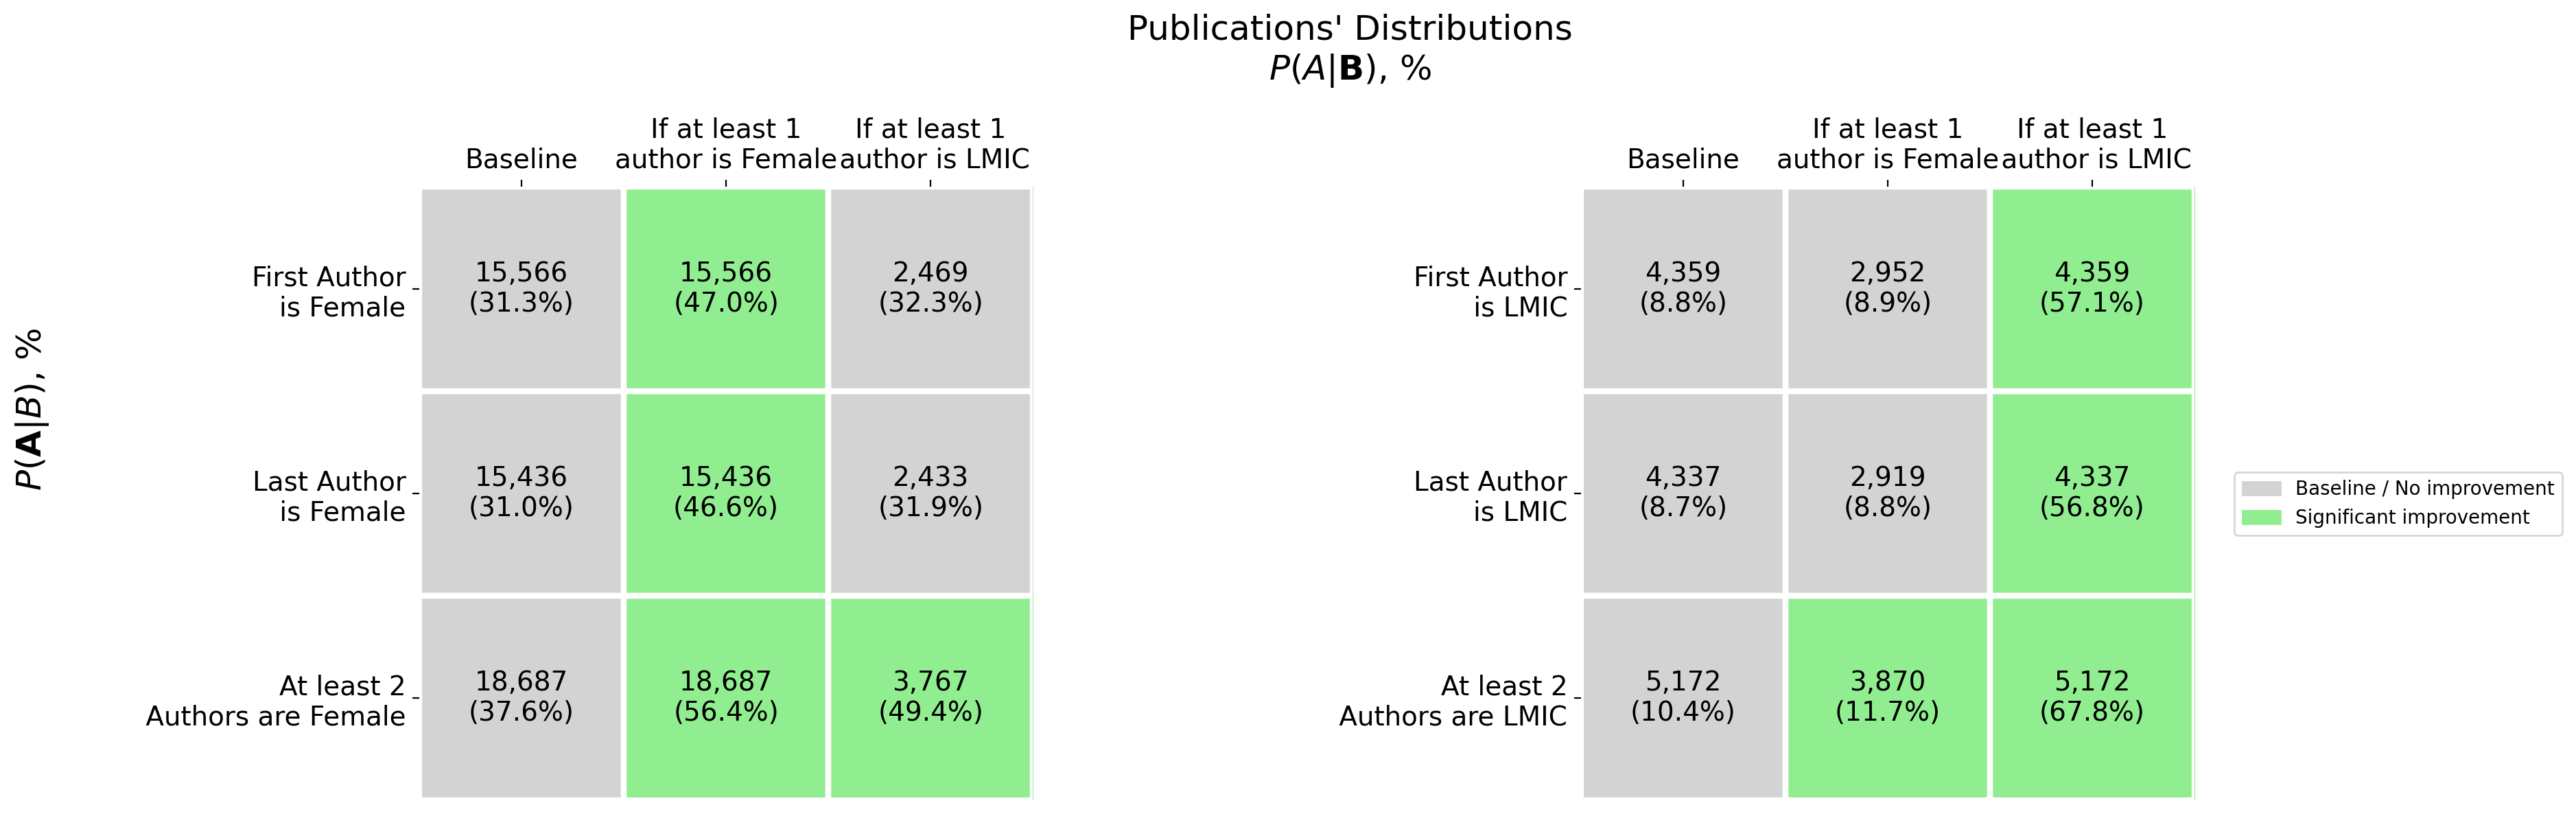

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pandas as pd

cmap = mcolors.ListedColormap(['lightgray', 'lightcoral', 'lightgreen'])

def plot_grouping_data(ax, label_rows, label_cols, yticklabels, xticklabels):
    label_matrix = np.empty((3, 3), dtype=object)
    color_matrix = np.zeros((3, 3), dtype=int)

    for i, row_label in enumerate(label_rows):
        for j, col_label in enumerate(label_cols):
            data_group = final_df[final_df['Grouping'] == col_label]
            data_group = data_group.set_index('Variable')
            label = data_group.loc[row_label, 'Cell']
            label_matrix[i, j] = label
            significant = data_group.loc[row_label, 'Significant']
            color_matrix[i, j] = significant  # 0 for 'gray', 1 for 'red', 2 for 'lightgreen'

    ax.imshow(color_matrix, cmap=cmap)

    for i in range(3):
        for j in range(3):
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=3, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
            ax.text(j, i, label_matrix[i, j], ha='center', va='center', fontsize=14)

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(xticklabels, fontsize=14)
    ax.set_yticklabels(yticklabels, fontsize=14)
    ax.xaxis.tick_top()

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

label_cols = ['marginal', 'at_least_one_female', 'at_least_one_lmic']
label_rows_gender = ['first_author_is_female', 'last_author_is_female', 'at_least_two_female']
label_rows_lmic = ['first_author_is_lmic', 'last_author_is_lmic', 'at_least_two_lmic']

xticklabels = ['Baseline', 'If at least 1\nauthor is Female', 'If at least 1\n author is LMIC']
yticklabels_gender = ['First Author\nis Female', 'Last Author\n is Female', 'At least 2\n Authors are Female']
yticklabels_lmic = ['First Author\n is LMIC', 'Last Author\nis LMIC', 'At least 2\n Authors are LMIC']

# Plot data for gender and LMIC
plot_grouping_data(axes[0], label_rows_gender, label_cols, yticklabels_gender, xticklabels)
plot_grouping_data(axes[1], label_rows_lmic, label_cols, yticklabels_lmic, xticklabels)

# Add legend
legend_labels = [
    patches.Patch(color='lightgray', label='Baseline / No improvement'),
    patches.Patch(color='lightgreen', label='Significant improvement'),
]

fig.suptitle("Publications' Distributions\n" + r"$P(A | \mathbf{B})$" + ", %", fontsize=18)


# Add sup ylabel with only A in bold
fig.text(0.02, 0.5, r"$P(\mathbf{A} | B)$" + ", %", va='center', ha='center', rotation='vertical', fontsize=18)


plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, .55), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
final_df

### plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# Define custom color mapping
cmap = mcolors.ListedColormap(['lightgray', 'lightcoral', 'lightgreen'])

# Creating a function to plot the data
def plot_grouping_data(ax, grouping_name, title_text):
    data_group = final_df[final_df['Grouping'] == grouping_name]
    data_group = data_group.set_index('Variable')

    label_matrix = np.empty((3, 2), dtype=object)
    color_matrix = np.zeros((3, 2), dtype=int)  # initialize with zeros (will be mapped to 'gray')

    # Dictionary to map variable names to matrix indices
    name_to_index = {
        'first_author_is_female': (0, 0),
        'first_author_is_lmic': (0, 1),
        'last_author_is_female': (1, 0),
        'last_author_is_lmic': (1, 1),
        'at_least_two_female': (2, 0),
        'at_least_two_lmic': (2, 1),
    }

    # Populate the matrices
    for variable, (i, j) in name_to_index.items():
        label = data_group.loc[variable, 'Cell']
        label_matrix[i, j] = label

        significant = data_group.loc[variable, 'Significant']

        if grouping_name == 'marginal':
            color_matrix[i, j] = 0
        else:
            marginal_value = float(final_df[(final_df['Grouping'] == 'marginal') & (final_df['Variable'] == variable)]['Cell'].values[0].split('\n')[0].replace(',', ''))
            current_value = float(label.split('\n')[0].replace(',', ''))

            if significant == 1:
                color_matrix[i, j] = 2 if current_value > marginal_value else 1
            else:
                color_matrix[i, j] = 0

    ax.imshow(color_matrix, cmap=cmap)

    for i in range(3):
        for j in range(2):
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=3, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
            ax.text(j, i, label_matrix[i, j], ha='center', va='center')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1, 2])
    ax.set_ylim([-.5, 2.5])
    ax.set_xticklabels(['Female', 'LMIC'])
    ax.set_yticklabels(['First Author is', 'Last Author is', 'At Least Two are'])
    ax.xaxis.tick_top()
    ax.set_title(title_text)

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(17, 6))

# Add supertitle
# fig.suptitle('Your Suptitle Here', fontsize=16, fontweight='bold')

# Plot data for each grouping
plot_grouping_data(axes[0], 'marginal', "Marginal Probabilities\n")
plot_grouping_data(axes[1], 'at_least_one_female', "At least one Female author in the team\n")
plot_grouping_data(axes[2], 'at_least_one_lmic', "At least one LMIC author in the team\n")

# Add legend
legend_labels = [patches.Patch(color='lightgray', label='No Significant Change'),
                 patches.Patch(color='lightgreen', label='Significant Improvement'),
                 patches.Patch(color='lightcoral', label='Significant Decline'),
                 ]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, .6), loc='upper left')

plt.tight_layout()
plt.show()
